In this file, I am going to collect all the required data for the project, and try to add them to the graph.

In [103]:
# importing libraries
import pandas as pd
import numpy as np
import os
import networkx as nx
import geopandas as gpd
from networkx.algorithms.threshold import degree_sequence
from sklearn.utils.estimator_checks import check_non_transformer_estimators_n_iter
from tqdm import tqdm
import shapely
from shapely.geometry import Point
import pickle
import re

In [104]:
# loading the adjacency matrix
adj_df = pd.read_csv('data/graph/cta_adj_mat_final.csv', index_col='Unnamed: 0')
print(adj_df.shape)
adj_df.head()


(144, 144)


,Cumberland,Oak Park-Lake,Austin-Lake,Ashland-Lake,Clinton-Lake,Grand/Milwaukee,Chicago/Milwaukee,Damen/Milwaukee,California/Milwaukee,Belmont-O'Hare,...,Southport,Adams/Wabash,Jackson/State,Rosemont,Harlem-Lake,Division/Milwaukee,95th/Dan Ryan,63rd-Dan Ryan,Garfield-Dan Ryan,Damen-Lake
Cumberland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Oak Park-Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Austin-Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ashland-Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
Clinton-Lake,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Adding the Damen green line station to the dataframe. DO NOT RUN ANYMORE

In [137]:
adj_df.loc["Ashland-Lake"].sum()

np.int64(3)

In [138]:
# adding a Damen/Lake column
adj_df['Damen-Lake'] = np.zeros(adj_df.shape[0])

# adding a Damen/Lake row
adj_df.loc['Damen-Lake'] = np.zeros(adj_df.shape[1])
adj_df.shape

(145, 145)

In [139]:
adj_df.columns[adj_df.loc[("Ashland-Lake")]==1], adj_df.columns[adj_df.loc[("California-Lake")]==1], adj_df.columns[adj_df.loc[("Damen-Lake")]==1]

(Index(['Morgan', 'California-Lake', 'Polk'], dtype='object'),
 Index(['Ashland-Lake', 'Kedzie-Lake'], dtype='object'),
 Index([], dtype='object'))

In [140]:
# ashland-lake to damen-lake and vice versa
adj_df.loc['Damen-Lake', 'Ashland-Lake'] = 1
adj_df.loc['Ashland-Lake', 'Damen-Lake'] = 1

# damen-alek to california-lake and vice versa
adj_df.loc['Damen-Lake', 'California-Lake'] = 1
adj_df.loc['California-Lake', 'Damen-Lake'] = 1

# removing ashland-lake and california-lake connections and vice versa
adj_df.loc['Ashland-Lake', 'California-Lake'] = 0
adj_df.loc['California-Lake', 'Ashland-Lake'] = 0

In [141]:
adj_df.columns[adj_df.loc[("Ashland-Lake")]==1], adj_df.columns[adj_df.loc[("California-Lake")]==1], adj_df.columns[adj_df.loc[("Damen-Lake")]==1]

(Index(['Morgan', 'Polk', 'Damen-Lake'], dtype='object'),
 Index(['Kedzie-Lake', 'Damen-Lake'], dtype='object'),
 Index(['Ashland-Lake', 'California-Lake'], dtype='object'))

In [142]:
# saving
adj_df.to_csv('data/graph/cta_adj_mat_final.csv')

## [TODO] Combining the stations that have multuiple occuerences in the adjacency dataframe but only occur once in the ridership table together

In [76]:
# adding connections of the red line to roosevelt/wabash
adj_df.loc['Roosevelt/Wabash', 'Harrison'] = 1.0
adj_df.loc['Harrison', 'Roosevelt/Wabash'] = 1.0

adj_df.loc['Roosevelt/Wabash', 'Cermak-Chinatown'] = 1.0
adj_df.loc['Cermak-Chinatown', 'Roosevelt/Wabash'] = 1.0

# dropping Roosevelt state
adj_df.drop(columns=['Roosevelt/State'], inplace=True)
adj_df.drop(index=['Roosevelt/State'], inplace=True)

In [99]:
# renaming roosevelt/State to roosevelt
adj_df.rename(index={'Roosevelt':"Roosevelt/Wabash"},columns={'Roosevelt':"Roosevelt/Wabash"}, inplace=True)

In [100]:
# saving
adj_df.to_csv('data//graph/cta_adj_mat_final.csv')

In [102]:
adj_df.columns[adj_df.loc['Roosevelt/Wabash']==1]

Index(['Harrison', 'Cermak-Chinatown', 'Library', 'Halsted-Midway',
       'Cermak-McCormick Place', 'Adams/Wabash'],
      dtype='object')

## Continuing from here

__NOTE__: Damen-Lake Coordinates: 443840.1312841872 4637228.542699575

In [105]:
# getting coordinates for damen-lake
from shapely.geometry import Point

lat, lon = 41.88499118845606, -87.67689573558924

# Create a GeoSeries in WGS84
g = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:4326")

# Convert to EPSG:26916
g_utm = g.to_crs("EPSG:26916")

print(g_utm.iloc[0].x, g_utm.iloc[0].y)

443840.1312841872 4637228.542699575


In [106]:
# loading the shapefile for stations
stations = gpd.read_file("data/l_stations/CTA_RailStations.shp")
print(stations.shape)
stations.head()

(144, 9)


,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry
0,230,Cumberland,Blue Line,5800 N. Cumberland Avenue,1,1,1.118914e+06,1.937256e+06,POINT (1118914.131 1937256.046)
1,1350,Oak Park-Lake,Green Line (Lake),100 S. Oak Park Avenue,0,0,1.131166e+06,1.901870e+06,POINT (1131166.01 1901870.067)
2,1260,Austin-Lake,Green Line (Lake),351 N. Austin Blvd,0,0,1.136515e+06,1.902016e+06,POINT (1136515.354 1902015.556)
3,170,Ashland-Lake,"Green (Lake), Pink",1601 W. Lake Street,1,0,1.165707e+06,1.901502e+06,POINT (1165706.564 1901501.957)
4,1160,Clinton-Lake,"Green (Lake), Pink",540 W. Lake Street,1,0,1.172562e+06,1.901699e+06,POINT (1172561.887 1901699.061)


In [107]:
print(stations.crs)

EPSG:3435


In [108]:
stations = stations.to_crs(epsg=26916)
stations.crs

<Projected CRS: EPSG:26916>
Name: NAD83 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 90°W and 84°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Alabama; Arkansas; Florida; Georgia; Indiana; Illinois; Kentucky; Louisiana; Michigan; Minnesota; Mississippi; Missouri; North Carolina; Ohio; Tennessee; Wisconsin.
- bounds: (-90.0, 23.97, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [109]:
stations[stations['LONGNAME'] == 'Roosevelt/Wabash']

,STATION_ID,LONGNAME,LINES,ADDRESS,ADA,PKNRD,POINT_X,POINT_Y,geometry
33,410,Roosevelt/Wabash,Orange & Green Lines,22 E. Roosevelt Road,1,0,1.176751e+06,1.895065e+06,POINT (447999.611 4635244.295)


Making the graph and adding a position for each node to make it look similar to the CTA map.

In [110]:
G = nx.from_pandas_adjacency(adj_df)
len(G.nodes())

144

In [111]:
# setting the position for each node
pos = {node:(stations[stations['LONGNAME']==node].geometry.x, stations[stations['LONGNAME']==node].geometry.y) for node in list(G.nodes()) if node!='Damen-Lake'}

In [113]:
pos2 = {k:(v[0].iloc[0], v[1].iloc[0]) for k,v in pos.items()}
# adding damen-lake coordinates
pos2['Damen-Lake'] = (np.float64(443840.1312841872), np.float64(4637228.542699575))

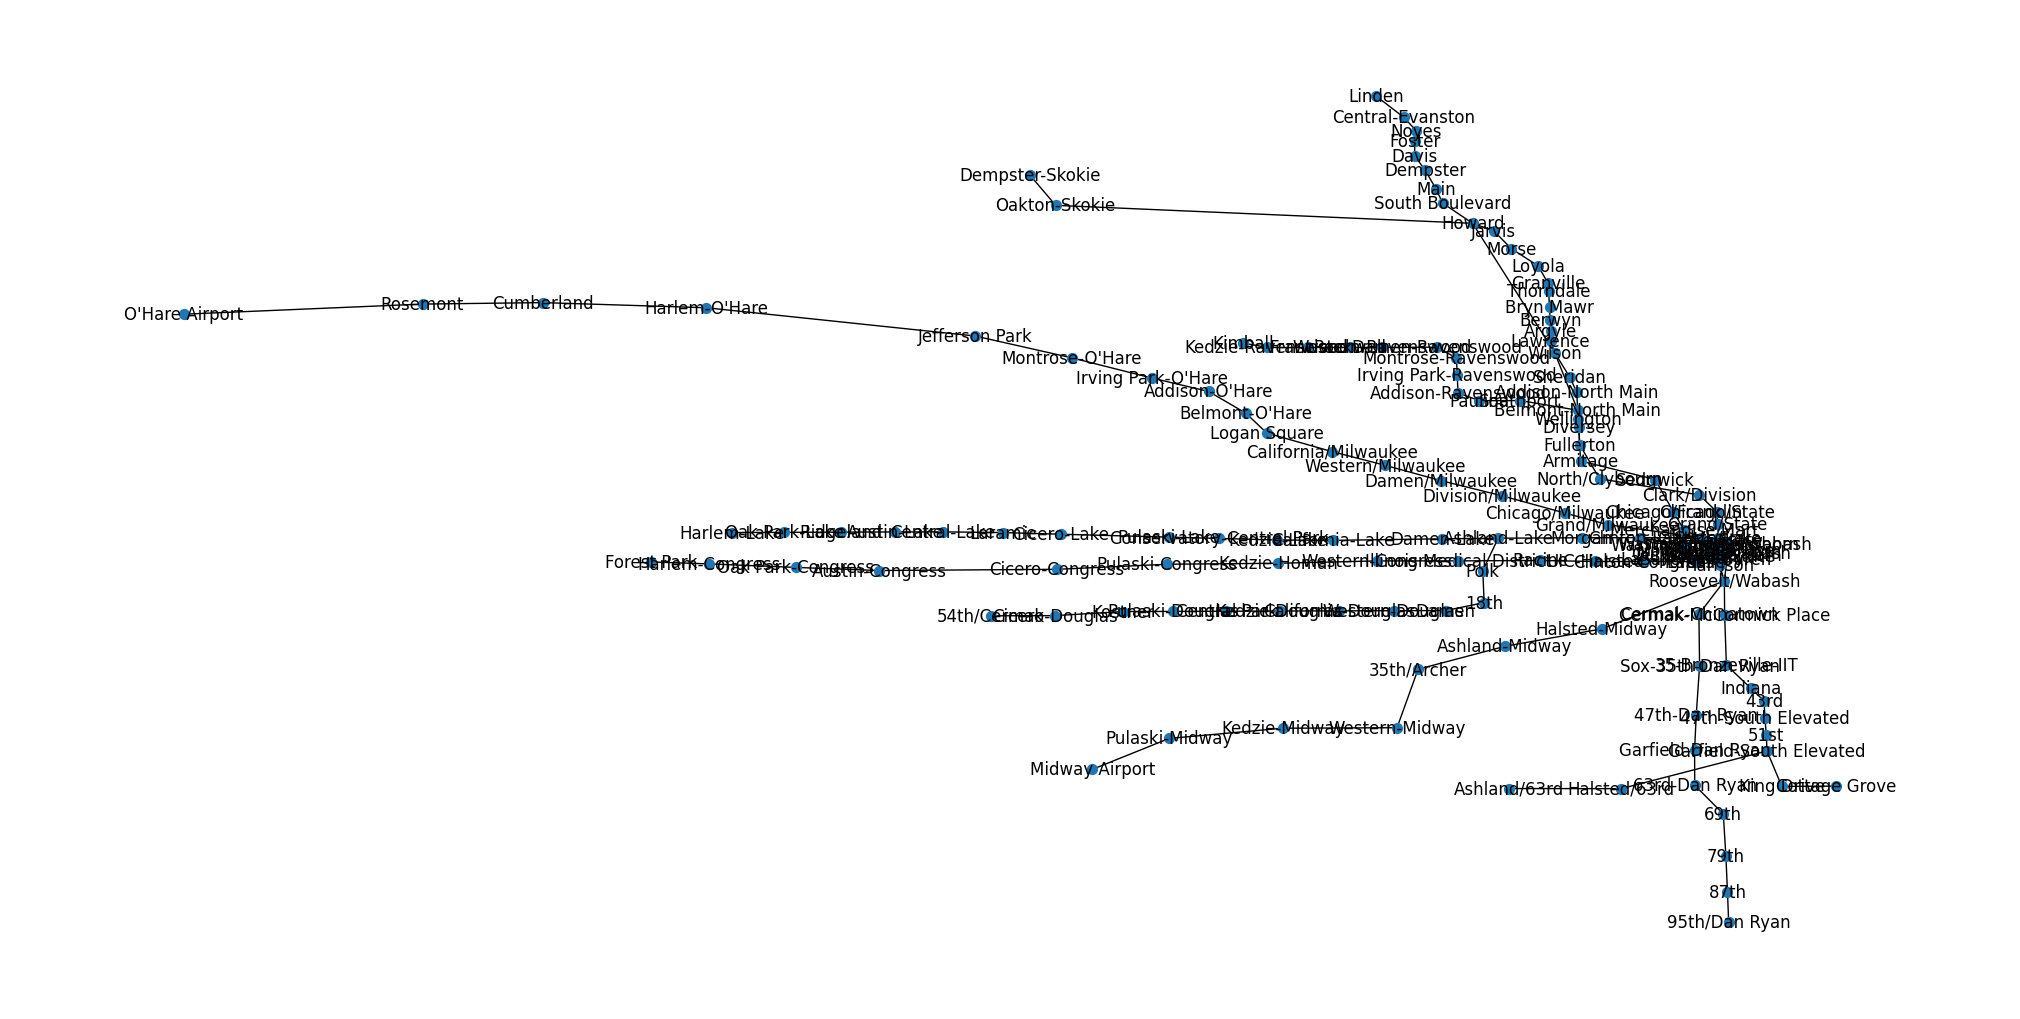

In [114]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
# pos = nx.get_node_attributes(G, 'pos')
nx.draw(G, pos2, with_labels=True, node_size=50)
plt.show()

So the graph works. I need to collect data now.

# Data Collection

## 1. Multimodal Data:

#### 1.1.Bus stations counts

In [115]:
# loading the bus stop shapefile
bus_stops = gpd.read_file("data/CTA_BusStops/CTA_BusStops.shp")
print(bus_stops.shape)
bus_stops.head()

(10760, 10)


,SYSTEMSTOP,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,OWLROUTES,CITY,PUBLIC_NAM,geometry
0,5282.0,JEFFERY,97TH STREET,NB,MT,15,None,CHICAGO,Jeffery & 97th Street,POINT (-87.57521 41.71888)
1,1143.0,STOCKTON,WEBSTER,NB,NT,"151,156",None,CHICAGO,Stockton & Webster,POINT (-87.63563 41.92192)
2,15703.0,HARLEM,SCHNEIDER,NB,NS,90,None,OAK PARK,Harlem & Schneider,POINT (-87.80512 41.89619)
3,6501.0,WENTWORTH,3200 SOUTH,SB,MB,"24,31",None,CHICAGO,3200 S Wentworth,POINT (-87.63168 41.83648)
4,1593.0,MICHIGAN,14TH STREET,SB,FS,"1,3,4",N4,CHICAGO,Michigan & 14th Street,POINT (-87.62419 41.86388)


In [116]:
print(bus_stops.crs)

EPSG:4326


In [117]:
bus_stops = bus_stops.to_crs(epsg=26916)
bus_stops.crs

<Projected CRS: EPSG:26916>
Name: NAD83 / UTM zone 16N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 90°W and 84°W - onshore and offshore. Canada - Manitoba; Nunavut; Ontario. United States (USA) - Alabama; Arkansas; Florida; Georgia; Indiana; Illinois; Kentucky; Louisiana; Michigan; Minnesota; Mississippi; Missouri; North Carolina; Ohio; Tennessee; Wisconsin.
- bounds: (-90.0, 23.97, -84.0, 84.0)
Coordinate Operation:
- name: UTM zone 16N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

#### Calculating if a busstop is within x metres of the station.

In [118]:
print(stations.crs), print(bus_stops.crs)

EPSG:26916
EPSG:26916


(None, None)

Instead of calculating pairwise distances, because that would not work very well, I am going to use GeoPandas + Shapely + an R-Tree spatial index approach which is faster.<br>
https://medium.com/@stacyfuende/python-spatial-indexing-accelerating-geographic-queries-f9bde82b8fe3<br>
The way this method works is:
1. For every l station, calculate a shapely buffer area from a given radius and get its bounds.
2. From all the bus stops, get those whose locations intersect with this buffer area.
3. From all these bus stops, get those which are not more than radius metres away from the l station.

In [119]:
# creating points for each station
pos_points = {n:Point(v) for n, v in pos2.items()}

In [120]:
# creating rindexes for bus stops
bus_sindex = bus_stops.sindex

In [121]:
# bounding box based query using R-Tree to speed up finding bus stops withing 500 m
radius = 500
counts = {}
for n, geom in tqdm(pos_points.items()):
    # creating a bounding box around the station
    bounding_box = list(geom.buffer(radius).bounds)
     # list(pos_points['35-Bronzeville-IIT'].buffer(500).bounds)
    # get the bus stops that intersect this bounding box
    possible_intersections_index = bus_sindex.intersection(bounding_box)

    # get their info
    possible_bus_stops = bus_stops.iloc[possible_intersections_index]

    # get all those who are less than radius distance
    in_range = possible_bus_stops[possible_bus_stops.distance(geom)<=radius]
    count_in_range = in_range.shape[0]

    # updating the dictionary
    counts[n] = count_in_range

100%|██████████| 144/144 [00:00<00:00, 1131.28it/s]


In [122]:
# saving this dictionary
with open('data/graph/bus_stop_counts.pkl', 'wb') as f:
    pickle.dump(counts, f)

#### 1.2. Getting Line Counts
I will use the same algorithm used above, however, instead of counting the station rows, I will just count the unique number of lines that these stations have.

In [123]:
# creating points for each station
pos_points = {n:Point(v) for n, v in pos2.items()}

# creating rindexes for bus stops
bus_sindex = bus_stops.sindex

In [124]:
# bounding box based query using R-Tree to speed up finding bus stops withing 500 m
radius = 500
line_counts = {}
for n, geom in tqdm(pos_points.items()):
    # creating a bounding box around the station
    bounding_box = list(geom.buffer(radius).bounds)
     # list(pos_points['35-Bronzeville-IIT'].buffer(500).bounds)
    # get the bus stops that intersect this bounding box
    possible_intersections_index = bus_sindex.intersection(bounding_box)

    # get their info
    possible_bus_stops = bus_stops.iloc[possible_intersections_index]

    # get all those who are less than radius distance
    in_range = possible_bus_stops[possible_bus_stops.distance(geom)<=radius]
    if in_range.shape[0]==0:
        line_counts[n] = 0
        continue
    # get all the unique lines for the stops
    stop_lines = in_range["ROUTESSTPG"]
    all_lines = [i.split(',') for i in stop_lines.values if i is not None]
    unique_lines = np.unique(np.array(np.concat(all_lines)))

    # updating the dictionary
    line_counts[n] = unique_lines.shape[0]

100%|██████████| 144/144 [00:00<00:00, 1116.42it/s]


In [125]:
# saving
with open('data/graph/bus_line_counts.pkl', 'wb') as f:
    pickle.dump(line_counts, f)

In [126]:
# creating the matrix for each node
micromodal_features = {}
for n in tqdm(G.nodes()):
    bus_stop_counts = counts[n]
    bus_line_counts = line_counts[n]
    micromodal_features[n] = [bus_stop_counts, bus_line_counts]

100%|██████████| 144/144 [00:00<00:00, 513588.24it/s]


In [127]:
# saving
with open('data/graph/micromodal/features.pkl', 'wb') as f:
    pickle.dump(micromodal_features, f)

In [128]:
len(micromodal_features)

144

#### 1.3. Taxi Dropoff and Pickup Data:
For the city of Chicago, taxi pickup and dropoff data, while available, is available on a much broader level. Meaning, the data has pickup and dropoff community area for each trip. A community area is very large, often having multiple stations for the same line within the same CA. Therefore, this data does not have the granularity that we need, and estimating using the CA might not be a good idea. Therefore, I am going to skip this data.
___
## 2. Network Structure
The network Structure data here is created for the latest graph, and hence, its not temporal. This data is re-created for all the different temporal graphs in a different notebook.

In [80]:
# making the graph again
metro_graph = nx.from_pandas_adjacency(adj_df)
len(metro_graph.nodes())

145

### 2.1. Centrality
For each station (node in the graph), calculate centrality values.

#### 2.1.1. Degree Centrality

In [81]:
degree_cent_measure = nx.degree_centrality(G)

#### 2.1.2. Closeness Centrality

In [91]:
closeness_cent_measure = nx.closeness_centrality(G)

#### 2.1.3. Betweenness Centrality

In [94]:
betweenness_cent_measure = nx.betweenness_centrality(G)

#### 2.1.4 Eigenvector Centrality
Idea behind parameter selection:
- max_iter: For the default 100 iterations, the algorithm wasnt converging, which is why, it was increased to 500. This is expected as while the l network is connected, its not fully connected, on an average, every node is connected to just 2 (except the hub and/or the loop stations).
- tol: This is the tolerance threshold for convergence. The default value of 1e-6 should be fine here.
- n_start: Using the default nstart value of 1 for each node.
- weights: default value, meaning all edges will be considered equal. Since the edges do not contain any weights/information, its okay to leave it at that.

In [99]:
eigenvector_cent_measure = nx.eigenvector_centrality(G, max_iter=500)

#### 2.1.5. Katz Centrality
Idea behind parameter selection:
- weights: set to default, which is none. Since the edges do not contain any weights, meaning every edge is equally important.
- n_start: using the default uniform values for each node.
- alpha: keeping the default value as 0.2, since it a very sparsely connected graph, and having higher alpha will mean that longer paths will contribute more, which might skew the results. The centrality of each node (station) should be less unless its a central hub station like Clark/Lake. I increased the value because with 0.1, the values did not have much difference between the hub stations, middle stations and ending stations of a line such as Clark/Lake, 35-Bronzeville-IIT and O'Hare Airport.
- beta: keeping as default, every node has the same baseline importance.

In [115]:
katz_cent_measure = nx.katz_centrality(G, alpha=0.2)

In [116]:
katz_cent_measure['Clark/Lake'], katz_cent_measure['Cumberland'], katz_cent_measure['35-Bronzeville-IIT'], katz_cent_measure["O'Hare Airport"], katz_cent_measure["Roosevelt/Wabash"]

(0.18777357625570723,
 0.07448308336024899,
 0.07723606628946567,
 0.059478315333047614,
 0.12253426036209207)

### 2.2. Degree of each node

In [120]:
degree_dict = dict(G.degree())

### 2.3. Is node an interchange?
If a node is connected to more than 2 stations, it is an interchange.

In [124]:
is_interchange = {}
for n, d in degree_dict.items():
    if d>2:
        is_interchange[n] = 1
    else:
        is_interchange[n] = 0

### 2.4. Is node a terminal station

In [157]:
is_terminal = {}
for n, d in degree_dict.items():
    if d==1:
        is_terminal[n] = 1
    else:
        is_terminal[n] = 0

Most of the stations are covered, however, stations such as Howard, that are the terminal station of one or more line, but have more than one connection because they still have one line running, need to be explicitly set to 1 in this dictionary.

In [166]:
# howard
is_terminal["Howard"] = 1
# looks like its just Howard, it's a unique station in this aspect

### 2.5. Number of lines passing.
For this, most will have 1, except for a few, most likely in the loop, and in the red line maybe.

In [173]:
station_lines = {n:1 for n in G.nodes()}

Manually need to do this

In [178]:
multiple = {
    'Ashland-Lake':2, 'Morgan':2, 'Clinton-Lake':2,
    'Clark/Lake':6, 'State/Lake':5, 'Washington/Wabash':5, 'Adams/Wabash':5, 'Library':4, 'LaSalle/Van Buren':4,
    'Quincy':4, 'Washington/Wells':4,
    'Roosevelt/Wabash':2,
    'Merchandise Mart':2, 'Sedgwick':2, 'Chicago/Franklin':2, 'Armitage':2, 'Diversey':2, 'Wellington':2,
    'Fullerton':3, 'Belmont-North Main':3, 'Wilson':2, 'Howard':3
}

In [181]:
for n in station_lines.keys():
    if n in list(multiple):
        station_lines[n] = multiple[n]

## 3. Built Environment Features

### 3.1. Population Density

To get the population density, we will be using the american community survey data to get the complete population. Since we want to get the population density, I am going to use block groups. This is because block groups are smaller than census tracts, and they can give a better and more accurate intersection with the stations.<br>
The population data will be sourced from 2023 American Community Survey for each block group in cook county. For the block group shapefile, we will use the [TIGER Shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html) from the Census bureau website. However, this gives the shapefiles for the entire state of Illinois. To get the shapefile for Chicago, we will be using the [City Boundaries Shapefile](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City-Map/ewy2-6yfk) from Chicago Data Portal.

In [129]:
# loading the shapefile for Illinois
il_shapefile = gpd.read_file('data/tl_2023_17_bg/tl_2023_17_bg.shp')
print(il_shapefile.shape)
il_shapefile.head()

(9898, 14)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,17,019,000800,1,170190008001,1500000US170190008001,Block Group 1,G5030,S,2551949,24,+40.1440140,-088.2485074,"POLYGON ((-88.25801 40.14907, -88.25226 40.149..."
1,17,019,010604,2,170190106042,1500000US170190106042,Block Group 2,G5030,S,106818681,3293,+40.1040759,-088.3977812,"POLYGON ((-88.46336 40.1285, -88.46333 40.1315..."
2,17,061,973800,1,170619738001,1500000US170619738001,Block Group 1,G5030,S,218423349,2912187,+39.2285546,-090.5112314,"POLYGON ((-90.61507 39.14813, -90.61465 39.153..."
3,17,061,973600,2,170619736002,1500000US170619736002,Block Group 2,G5030,S,162294738,143002,+39.2505118,-090.2817465,"POLYGON ((-90.39977 39.24762, -90.39945 39.247..."
4,17,031,400500,2,170314005002,1500000US170314005002,Block Group 2,G5030,S,136542,0,+41.7890538,-087.6228061,"POLYGON ((-87.62556 41.78919, -87.62524 41.789..."


In [130]:
# loading the city boundaries
city_boundary = gpd.read_file('data/Chicago_Boundary/geo_export_d4bb75d9-b8ae-4b69-aca4-be4568ecdfa1.shp')
print(city_boundary.shape)
city_boundary.head()

(1, 5)


,shape_area,name,objectid,shape_len,geometry
0,6.450277e+09,CHICAGO,1.0,845282.931362,"MULTIPOLYGON (((-87.93514 42.00089, -87.93521 ..."


In [131]:
# Getting the shapefiles for block groups in the city of Chicago
# ensuring theyre in the same crs system
il_shapefile = il_shapefile.to_crs(city_boundary.crs)

# filtering by overlaying the city limits bounding box over the state block group shapefile
chicago_bg_shapefiles = gpd.overlay(il_shapefile, city_boundary, how='intersection')

In [132]:
print(chicago_bg_shapefiles.crs)
# converting to epsg26916
chicago_bg_shapefiles = chicago_bg_shapefiles.to_crs(epsg=26916)
print(chicago_bg_shapefiles.crs)

EPSG:4326
EPSG:26916


In [133]:
print(chicago_bg_shapefiles.shape)
chicago_bg_shapefiles.head()

(2313, 18)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,shape_area,name,objectid,shape_len,geometry
0,17,031,400500,2,170314005002,1500000US170314005002,Block Group 2,G5030,S,136542,0,+41.7890538,-087.6228061,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((448048.523 4626559.895, 448088.58 46..."
1,17,031,480400,6,170314804006,1500000US170314804006,Block Group 6,G5030,S,229016,0,+41.7306299,-087.5787101,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451323.307 4620125.736, 451331.375 4..."
2,17,031,480400,7,170314804007,1500000US170314804007,Block Group 7,G5030,S,232476,0,+41.7324658,-087.5788122,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451321.551 4620332.152, 451329.46 46..."
3,17,031,060800,4,170310608004,1500000US170310608004,Block Group 4,G5030,S,45144,0,+41.9530301,-087.6469080,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((446322.611 4644937.922, 446386.686 4..."
4,17,031,290900,1,170312909001,1500000US170312909001,Block Group 1,G5030,S,164717,0,+41.8643125,-087.7275607,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((439431.485 4635167.646, 439492.743 4..."


In [134]:
# loading the population data
population_data = pd.read_csv('data/ACS_population/Data.csv')
print(population_data.shape)
population_data.head()

(4002, 4)


,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total
0,1500000US170310101001,Block Group 1; Census Tract 101; Cook County; ...,646,372
1,1500000US170310101002,Block Group 2; Census Tract 101; Cook County; ...,1395,474
2,1500000US170310101003,Block Group 3; Census Tract 101; Cook County; ...,1685,450
3,1500000US170310102011,Block Group 1; Census Tract 102.01; Cook Count...,2195,890
4,1500000US170310102012,Block Group 2; Census Tract 102.01; Cook Count...,1664,558


Joining the two to get population for each block group.

In [135]:
population_data['GEOID'] = population_data['Geography'].apply(lambda g: g.split('US')[1])
population_data.head()

,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,GEOID
0,1500000US170310101001,Block Group 1; Census Tract 101; Cook County; ...,646,372,170310101001
1,1500000US170310101002,Block Group 2; Census Tract 101; Cook County; ...,1395,474,170310101002
2,1500000US170310101003,Block Group 3; Census Tract 101; Cook County; ...,1685,450,170310101003
3,1500000US170310102011,Block Group 1; Census Tract 102.01; Cook Count...,2195,890,170310102011
4,1500000US170310102012,Block Group 2; Census Tract 102.01; Cook Count...,1664,558,170310102012


In [136]:
# joining
blocks_with_population = pd.merge(left=chicago_bg_shapefiles, right=population_data, on='GEOID', how='inner')
blocks_with_population.shape

(2310, 22)

In [137]:
blocks_with_population.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,INTPTLON,shape_area,name,objectid,shape_len,geometry,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total
0,17,031,400500,2,170314005002,1500000US170314005002,Block Group 2,G5030,S,136542,...,-087.6228061,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((448048.523 4626559.895, 448088.58 46...",1500000US170314005002,Block Group 2; Census Tract 4005; Cook County;...,1021,417
1,17,031,480400,6,170314804006,1500000US170314804006,Block Group 6,G5030,S,229016,...,-087.5787101,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451323.307 4620125.736, 451331.375 4...",1500000US170314804006,Block Group 6; Census Tract 4804; Cook County;...,991,803
2,17,031,480400,7,170314804007,1500000US170314804007,Block Group 7,G5030,S,232476,...,-087.5788122,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451321.551 4620332.152, 451329.46 46...",1500000US170314804007,Block Group 7; Census Tract 4804; Cook County;...,548,201
3,17,031,060800,4,170310608004,1500000US170310608004,Block Group 4,G5030,S,45144,...,-087.6469080,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((446322.611 4644937.922, 446386.686 4...",1500000US170310608004,Block Group 4; Census Tract 608; Cook County; ...,2113,390
4,17,031,290900,1,170312909001,1500000US170312909001,Block Group 1,G5030,S,164717,...,-087.7275607,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((439431.485 4635167.646, 439492.743 4...",1500000US170312909001,Block Group 1; Census Tract 2909; Cook County;...,597,445


Blocks with population is the final data that we will use.<br>
NOTE ABOUT USING THIS DATA: The ACS data has a margin of error as well, which are high for some and low for others. Instead of removing it, I am going to get two things, average population around each station, and it's average measure of error:
- _Average Population:_ Average across all the block groups that fall in the 500m radius.
- _Average Error:_ Average of error.

Another thing to note is that in the radius, the intersection is not always going to be complete, instead, it can also be varying degrees of partial intersections as well. To take care of this and to make things simple, I am going to just calculate the centroid for each block group and calculate intersection with the centroid.

In [138]:
# calculating the error percentage value for each bg
blocks_with_population['error_percent'] = blocks_with_population.apply(lambda row: row["Margin of Error!!Total"]/row["Estimate!!Total"] if row["Estimate!!Total"]>0 else -1, axis=1) # margin of error is set to 0 if the population was 0, this can happen if the block group does not have anyone living in it as well
print(blocks_with_population.shape)
blocks_with_population.head()

(2310, 23)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,shape_area,name,objectid,shape_len,geometry,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,error_percent
0,17,031,400500,2,170314005002,1500000US170314005002,Block Group 2,G5030,S,136542,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((448048.523 4626559.895, 448088.58 46...",1500000US170314005002,Block Group 2; Census Tract 4005; Cook County;...,1021,417,0.408423
1,17,031,480400,6,170314804006,1500000US170314804006,Block Group 6,G5030,S,229016,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451323.307 4620125.736, 451331.375 4...",1500000US170314804006,Block Group 6; Census Tract 4804; Cook County;...,991,803,0.810293
2,17,031,480400,7,170314804007,1500000US170314804007,Block Group 7,G5030,S,232476,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451321.551 4620332.152, 451329.46 46...",1500000US170314804007,Block Group 7; Census Tract 4804; Cook County;...,548,201,0.366788
3,17,031,060800,4,170310608004,1500000US170310608004,Block Group 4,G5030,S,45144,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((446322.611 4644937.922, 446386.686 4...",1500000US170310608004,Block Group 4; Census Tract 608; Cook County; ...,2113,390,0.184572
4,17,031,290900,1,170312909001,1500000US170312909001,Block Group 1,G5030,S,164717,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((439431.485 4635167.646, 439492.743 4...",1500000US170312909001,Block Group 1; Census Tract 2909; Cook County;...,597,445,0.745394


In [139]:
# calculating centroid for each block group
blocks_with_population['bg_centroid'] = blocks_with_population['geometry'].apply(lambda g: g.centroid)
print(blocks_with_population.shape)
blocks_with_population.head()

(2310, 24)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,name,objectid,shape_len,geometry,Geography,Geographic Area Name,Estimate!!Total,Margin of Error!!Total,error_percent,bg_centroid
0,17,031,400500,2,170314005002,1500000US170314005002,Block Group 2,G5030,S,136542,...,CHICAGO,1.0,845282.931362,"POLYGON ((448048.523 4626559.895, 448088.58 46...",1500000US170314005002,Block Group 2; Census Tract 4005; Cook County;...,1021,417,0.408423,POINT (448250.56 4626542.978)
1,17,031,480400,6,170314804006,1500000US170314804006,Block Group 6,G5030,S,229016,...,CHICAGO,1.0,845282.931362,"POLYGON ((451323.307 4620125.736, 451331.375 4...",1500000US170314804006,Block Group 6; Census Tract 4804; Cook County;...,991,803,0.810293,POINT (451870.909 4620030.864)
2,17,031,480400,7,170314804007,1500000US170314804007,Block Group 7,G5030,S,232476,...,CHICAGO,1.0,845282.931362,"POLYGON ((451321.551 4620332.152, 451329.46 46...",1500000US170314804007,Block Group 7; Census Tract 4804; Cook County;...,548,201,0.366788,POINT (451863.794 4620234.757)
3,17,031,060800,4,170310608004,1500000US170310608004,Block Group 4,G5030,S,45144,...,CHICAGO,1.0,845282.931362,"POLYGON ((446322.611 4644937.922, 446386.686 4...",1500000US170310608004,Block Group 4; Census Tract 608; Cook County; ...,2113,390,0.184572,POINT (446385.114 4644763.58)
4,17,031,290900,1,170312909001,1500000US170312909001,Block Group 1,G5030,S,164717,...,CHICAGO,1.0,845282.931362,"POLYGON ((439431.485 4635167.646, 439492.743 4...",1500000US170312909001,Block Group 1; Census Tract 2909; Cook County;...,597,445,0.745394,POINT (439617.138 4634967.035)


Calculating intersection

In [140]:
# creating a dataframe that only contains the centroids and not the geometry, to make sure that we get sindexes using the correct value
# im not sure if this is even a problem, but doing it just to be sure
final_pop_data = blocks_with_population[['bg_centroid', 'Estimate!!Total', 'error_percent', 'GEOID']]
# setting the geometry
final_pop_data = final_pop_data.set_geometry('bg_centroid')
final_pop_data.shape

(2310, 4)

In [141]:
print(final_pop_data.crs)

EPSG:26916


In [142]:
blocks_with_population['bg_centroid'].value_counts()

bg_centroid
POINT (448250.56 4626542.978)     1
POINT (451870.909 4620030.864)    1
POINT (451863.794 4620234.757)    1
POINT (446385.114 4644763.58)     1
POINT (439617.138 4634967.035)    1
                                 ..
POINT (435858.282 4640194.095)    1
POINT (452724.539 4621759.068)    1
POINT (453289.862 4616727.316)    1
POINT (442636.597 4628928.893)    1
POINT (444597.743 4625703.695)    1
Name: count, Length: 2310, dtype: int64

In [143]:
# getting the coordinates of the stations
pos_points = {n:Point(v) for n, v in pos2.items()}

# creating the sindex
final_pop_sindex = final_pop_data.sindex

In [144]:
# bounding box based query using R-Tree to speed up finding bus stops withing 500 m
radius = 500
population_averages = {}
for n, geom in tqdm(pos_points.items()):
    # creating a bounding box around the station
    bounding_box = list(geom.buffer(radius).bounds)
     # list(pos_points['35-Bronzeville-IIT'].buffer(500).bounds)
    # get the bus stops that intersect this bounding box
    possible_intersections_index = final_pop_sindex.intersection(bounding_box)

    # get their info
    possible_bg = final_pop_data.iloc[possible_intersections_index]

    # get all those who are less than radius distance
    in_range = possible_bg[possible_bg.distance(geom)<=radius]
    # filtering the in_range to ensure we do not get any bgs that have a 0 estimate and error measure as -1
    in_range = in_range[in_range['error_percent']!=-1]
    # if we did not find anything, just add a 0 for everything for the station
    if in_range.shape[0]==0:
        population_averages[n] = [0, 0, 0]
        continue
    # get the mean population and error measure, and the number of block groups
    mean_pop = float(in_range['Estimate!!Total'].mean())
    mean_error = float(in_range['error_percent'].mean())

    # updating the dictionary
    population_averages[n] = [mean_pop, mean_error, in_range.shape[0]]

100%|██████████| 144/144 [00:00<00:00, 830.94it/s]


### 3.2. Median Housing Value
I am going to collect the median (median) housing value using the same approach done above.

In [145]:
# loading the housing value data
house_value = pd.read_csv('data/median_house_value/Data.csv')
print(house_value.shape)
house_value.head()

(4002, 4)


,Geography,Geographic Area Name,Estimate!!Median value (dollars),Margin of Error!!Median value (dollars)
0,1500000US170310101001,Block Group 1; Census Tract 101; Cook County; ...,367800,110762
1,1500000US170310101002,Block Group 2; Census Tract 101; Cook County; ...,540700,469886
2,1500000US170310101003,Block Group 3; Census Tract 101; Cook County; ...,267000,44431
3,1500000US170310102011,Block Group 1; Census Tract 102.01; Cook Count...,221500,108068
4,1500000US170310102012,Block Group 2; Census Tract 102.01; Cook Count...,291000,192628


In [146]:
house_value['GEOID'] = house_value['Geography'].apply(lambda g: g.split('US')[1])
house_value.head()

,Geography,Geographic Area Name,Estimate!!Median value (dollars),Margin of Error!!Median value (dollars),GEOID
0,1500000US170310101001,Block Group 1; Census Tract 101; Cook County; ...,367800,110762,170310101001
1,1500000US170310101002,Block Group 2; Census Tract 101; Cook County; ...,540700,469886,170310101002
2,1500000US170310101003,Block Group 3; Census Tract 101; Cook County; ...,267000,44431,170310101003
3,1500000US170310102011,Block Group 1; Census Tract 102.01; Cook Count...,221500,108068,170310102011
4,1500000US170310102012,Block Group 2; Census Tract 102.01; Cook Count...,291000,192628,170310102012


In [147]:
# joining
blocks_with_median_hv = pd.merge(left=chicago_bg_shapefiles, right=house_value, on='GEOID', how='inner')
blocks_with_median_hv.shape

(2310, 22)

In [148]:
blocks_with_median_hv.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,INTPTLON,shape_area,name,objectid,shape_len,geometry,Geography,Geographic Area Name,Estimate!!Median value (dollars),Margin of Error!!Median value (dollars)
0,17,031,400500,2,170314005002,1500000US170314005002,Block Group 2,G5030,S,136542,...,-087.6228061,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((448048.523 4626559.895, 448088.58 46...",1500000US170314005002,Block Group 2; Census Tract 4005; Cook County;...,-,**
1,17,031,480400,6,170314804006,1500000US170314804006,Block Group 6,G5030,S,229016,...,-087.5787101,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451323.307 4620125.736, 451331.375 4...",1500000US170314804006,Block Group 6; Census Tract 4804; Cook County;...,204000,35343
2,17,031,480400,7,170314804007,1500000US170314804007,Block Group 7,G5030,S,232476,...,-087.5788122,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451321.551 4620332.152, 451329.46 46...",1500000US170314804007,Block Group 7; Census Tract 4804; Cook County;...,159500,62256
3,17,031,060800,4,170310608004,1500000US170310608004,Block Group 4,G5030,S,45144,...,-087.6469080,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((446322.611 4644937.922, 446386.686 4...",1500000US170310608004,Block Group 4; Census Tract 608; Cook County; ...,322600,117955
4,17,031,290900,1,170312909001,1500000US170312909001,Block Group 1,G5030,S,164717,...,-087.7275607,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((439431.485 4635167.646, 439492.743 4...",1500000US170312909001,Block Group 1; Census Tract 2909; Cook County;...,-,**


In [149]:
def replace_val(val):
    # replace if value == replace_if, else return float of val
    new_val = re.sub(r"[^0-9]+", "", val)
    if new_val == '':
        return 0.0
    else:
        return float(new_val)
# converting string for estimate to floats
replaced = blocks_with_median_hv['Estimate!!Median value (dollars)'].apply(lambda v: replace_val(v))
blocks_with_median_hv['Estimate!!Median value (dollars)'] = replaced

# converting string for margin ot error to floats
replaced = blocks_with_median_hv['Margin of Error!!Median value (dollars)'].apply(lambda v: replace_val(v))
blocks_with_median_hv['Margin of Error!!Median value (dollars)'] = replaced

blocks_with_median_hv.head()

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,INTPTLON,shape_area,name,objectid,shape_len,geometry,Geography,Geographic Area Name,Estimate!!Median value (dollars),Margin of Error!!Median value (dollars)
0,17,031,400500,2,170314005002,1500000US170314005002,Block Group 2,G5030,S,136542,...,-087.6228061,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((448048.523 4626559.895, 448088.58 46...",1500000US170314005002,Block Group 2; Census Tract 4005; Cook County;...,0.0,0.0
1,17,031,480400,6,170314804006,1500000US170314804006,Block Group 6,G5030,S,229016,...,-087.5787101,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451323.307 4620125.736, 451331.375 4...",1500000US170314804006,Block Group 6; Census Tract 4804; Cook County;...,204000.0,35343.0
2,17,031,480400,7,170314804007,1500000US170314804007,Block Group 7,G5030,S,232476,...,-087.5788122,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451321.551 4620332.152, 451329.46 46...",1500000US170314804007,Block Group 7; Census Tract 4804; Cook County;...,159500.0,62256.0
3,17,031,060800,4,170310608004,1500000US170310608004,Block Group 4,G5030,S,45144,...,-087.6469080,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((446322.611 4644937.922, 446386.686 4...",1500000US170310608004,Block Group 4; Census Tract 608; Cook County; ...,322600.0,117955.0
4,17,031,290900,1,170312909001,1500000US170312909001,Block Group 1,G5030,S,164717,...,-087.7275607,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((439431.485 4635167.646, 439492.743 4...",1500000US170312909001,Block Group 1; Census Tract 2909; Cook County;...,0.0,0.0


In [150]:
# calculating the error percentage value for each bg
blocks_with_median_hv['error_percent'] = blocks_with_median_hv.apply(lambda row: row["Margin of Error!!Median value (dollars)"]/row["Estimate!!Median value (dollars)"] if row["Estimate!!Median value (dollars)"]>0 else -1, axis=1) # margin of error is set to 0 if the population was 0, this can happen if the block group does not have anyone living in it as well
print(blocks_with_median_hv.shape)
blocks_with_median_hv.head()

(2310, 23)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,shape_area,name,objectid,shape_len,geometry,Geography,Geographic Area Name,Estimate!!Median value (dollars),Margin of Error!!Median value (dollars),error_percent
0,17,031,400500,2,170314005002,1500000US170314005002,Block Group 2,G5030,S,136542,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((448048.523 4626559.895, 448088.58 46...",1500000US170314005002,Block Group 2; Census Tract 4005; Cook County;...,0.0,0.0,-1.000000
1,17,031,480400,6,170314804006,1500000US170314804006,Block Group 6,G5030,S,229016,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451323.307 4620125.736, 451331.375 4...",1500000US170314804006,Block Group 6; Census Tract 4804; Cook County;...,204000.0,35343.0,0.173250
2,17,031,480400,7,170314804007,1500000US170314804007,Block Group 7,G5030,S,232476,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((451321.551 4620332.152, 451329.46 46...",1500000US170314804007,Block Group 7; Census Tract 4804; Cook County;...,159500.0,62256.0,0.390320
3,17,031,060800,4,170310608004,1500000US170310608004,Block Group 4,G5030,S,45144,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((446322.611 4644937.922, 446386.686 4...",1500000US170310608004,Block Group 4; Census Tract 608; Cook County; ...,322600.0,117955.0,0.365639
4,17,031,290900,1,170312909001,1500000US170312909001,Block Group 1,G5030,S,164717,...,6.450277e+09,CHICAGO,1.0,845282.931362,"POLYGON ((439431.485 4635167.646, 439492.743 4...",1500000US170312909001,Block Group 1; Census Tract 2909; Cook County;...,0.0,0.0,-1.000000


In [151]:
# calculating centroid for each block group
blocks_with_median_hv['bg_centroid'] = blocks_with_median_hv['geometry'].apply(lambda g: g.centroid)
print(blocks_with_median_hv.shape)
blocks_with_median_hv.head()

(2310, 24)


,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,GEOIDFQ,NAMELSAD,MTFCC,FUNCSTAT,ALAND,...,name,objectid,shape_len,geometry,Geography,Geographic Area Name,Estimate!!Median value (dollars),Margin of Error!!Median value (dollars),error_percent,bg_centroid
0,17,031,400500,2,170314005002,1500000US170314005002,Block Group 2,G5030,S,136542,...,CHICAGO,1.0,845282.931362,"POLYGON ((448048.523 4626559.895, 448088.58 46...",1500000US170314005002,Block Group 2; Census Tract 4005; Cook County;...,0.0,0.0,-1.000000,POINT (448250.56 4626542.978)
1,17,031,480400,6,170314804006,1500000US170314804006,Block Group 6,G5030,S,229016,...,CHICAGO,1.0,845282.931362,"POLYGON ((451323.307 4620125.736, 451331.375 4...",1500000US170314804006,Block Group 6; Census Tract 4804; Cook County;...,204000.0,35343.0,0.173250,POINT (451870.909 4620030.864)
2,17,031,480400,7,170314804007,1500000US170314804007,Block Group 7,G5030,S,232476,...,CHICAGO,1.0,845282.931362,"POLYGON ((451321.551 4620332.152, 451329.46 46...",1500000US170314804007,Block Group 7; Census Tract 4804; Cook County;...,159500.0,62256.0,0.390320,POINT (451863.794 4620234.757)
3,17,031,060800,4,170310608004,1500000US170310608004,Block Group 4,G5030,S,45144,...,CHICAGO,1.0,845282.931362,"POLYGON ((446322.611 4644937.922, 446386.686 4...",1500000US170310608004,Block Group 4; Census Tract 608; Cook County; ...,322600.0,117955.0,0.365639,POINT (446385.114 4644763.58)
4,17,031,290900,1,170312909001,1500000US170312909001,Block Group 1,G5030,S,164717,...,CHICAGO,1.0,845282.931362,"POLYGON ((439431.485 4635167.646, 439492.743 4...",1500000US170312909001,Block Group 1; Census Tract 2909; Cook County;...,0.0,0.0,-1.000000,POINT (439617.138 4634967.035)


Getting the intersection

In [152]:
# creating a dataframe that only contains the centroids and not the geometry, to make sure that we get sindexes using the correct value
# im not sure if this is even a problem, but doing it just to be sure
final_median_hv_data = blocks_with_median_hv[['bg_centroid', 'Estimate!!Median value (dollars)', 'error_percent', 'GEOID']]
# setting the geometry
final_median_hv_data = final_median_hv_data.set_geometry('bg_centroid')
final_median_hv_data.shape

(2310, 4)

In [153]:
final_median_hv_data.head()

,bg_centroid,Estimate!!Median value (dollars),error_percent,GEOID
0,POINT (448250.56 4626542.978),0.0,-1.000000,170314005002
1,POINT (451870.909 4620030.864),204000.0,0.173250,170314804006
2,POINT (451863.794 4620234.757),159500.0,0.390320,170314804007
3,POINT (446385.114 4644763.58),322600.0,0.365639,170310608004
4,POINT (439617.138 4634967.035),0.0,-1.000000,170312909001


In [154]:
print(final_median_hv_data.crs)

EPSG:26916


In [155]:
# getting the coordinates of the stations
pos_points = {n:Point(v) for n, v in pos2.items()}

# creating the sindex
final_median_hv_sindex = final_median_hv_data.sindex

In [156]:
# bounding box based query using R-Tree to speed up finding bus stops withing 500 m
radius = 500
housing_val_median = {}
for n, geom in tqdm(pos_points.items()):
    # creating a bounding box around the station
    bounding_box = list(geom.buffer(radius).bounds)
     # list(pos_points['35-Bronzeville-IIT'].buffer(500).bounds)
    # get the bus stops that intersect this bounding box
    possible_intersections_index = final_median_hv_sindex.intersection(bounding_box)

    # get their info
    possible_bg = final_median_hv_data.iloc[possible_intersections_index]

    # get all those who are less than radius distance
    in_range = possible_bg[possible_bg.distance(geom)<=radius]
    # filtering the in_range to ensure we do not get any bgs that have a 0 estimate and error measure as -1
    in_range = in_range[in_range['error_percent']!=-1]
    # if we did not find anything, just add a 0 for everything for the station
    if in_range.shape[0]==0:
        housing_val_median[n] = [0, 0, 0]
        continue
    # get the mean population and error measure, and the number of block groups
    mean_pop = float(in_range['Estimate!!Median value (dollars)'].mean())
    mean_error = float(in_range['error_percent'].mean())

    # updating the dictionary
    housing_val_median[n] = [mean_pop, mean_error, in_range.shape[0]]

100%|██████████| 144/144 [00:00<00:00, 849.71it/s]


In [157]:
housing_val_median['Cumberland'], housing_val_median['Clark/Lake'], housing_val_median['35-Bronzeville-IIT']

([146200.0, 0.3971477428180575, 1],
 [288300.0, 0.5330489073881374, 1],
 [398333.3333333333, 0.6390720002249011, 3])

In [158]:
# creating the final matrix to save
built_env_features = {}
for n in tqdm(G.nodes()):
    pop = population_averages[n]
    median_hv = housing_val_median[n]
    built_env_features[n] = [pop, median_hv]

100%|██████████| 144/144 [00:00<00:00, 458602.72it/s]


In [159]:
with open('data/graph/built_env/features.pkl', 'wb') as f:
    pickle.dump(built_env_features, f)

## 4. Temporal Data

### 4.1. Age of the station in months
- For this, I am going to calculate the age of each station in months as of November 2025. Source of age: https://www.chicago-l.org/stations/index.html
- For stations that do not have an opening date, just an opening year, I am going to assume that the opening date was Jan 1 of that year.